基于BSM模型，有风险的标的（股票或指数水平等），在风险中性的假设下，会遵循几何布朗运动，以随机微分方程的形式表现如下：$$dS_t=rS_tdt+\sigma S_tdZ_t$$


这里的Z表示的是标准布朗运动。

将该方程离散化为可以使用Monte Carlo方法处理的差分方程如下：
$$S_t=S_{t-\Delta t}e^{(r-0.5\sigma^2)\Delta t+\sigma \sqrt{\Delta t} z_t}$$

这里的z表示的是标准正态分布随机变量，t表示的是一个足够小的时间区间，且0<t<T

下面举例模拟定价一个欧式期权：基本参数设置如下

In [3]:
S0=100.0
K=105.0
T=1.0
r=0.05
sigma=0.2

根据BSM模型计算出来的期权期望价值为：

In [5]:
def bsm_call_value(S0,K,T,r,sigma):
    from math import log,sqrt,exp
    from scipy import stats
    S0=float(S0)
    d1=(log(S0/K)+(r+0.5*sigma**2)*T)/(sigma*sqrt(T))
    d2=(log(S0/K)+(r-0.5*sigma**2)*T)/(sigma*sqrt(T))
    value=(S0*stats.norm.cdf(d1,0.0,1.0))-K*exp(-r*T)*stats.norm.cdf(d2,0.0,1.0)
    return value

In [8]:
callvalue=bsm_call_value(S0,K,T,r,sigma)

In [9]:
callvalue

8.0213522351431763

期权的期望价值为8.02135。

Monte Carlo模拟为期权定价的过程需要下面几个步骤：

将时间区间[0,T]分为相等的每段为t的间隔；

开始迭代i=1,2,3,....l(l是模拟的路径数）

对于每个时间间隔t,抽取伪随机数$z_t(i)$

通过在每个时间步骤应用上述伪随机数和上面给出的离散化方程来确定T时刻的指数水平$S_T(i)$

决定欧式看涨期权在T时刻的内在价值$h_T(S_T(i))=max(S_T(i)-K,0)$

进行迭代直到$i=l$

加总每条路径的内在价值，并求平均数。

$$C_0=e^{-rT}\frac{1}{I}\sum_{I}(h_T(S_T(i))$$

下面用Python编写三种实现Monte Carlo模拟的代码：

1. 使用Python内嵌的list方法

In [10]:
from time import time
from math import exp,sqrt,log
from random import gauss,seed

In [16]:
seed(20000)
t0=time()#计时
M=50
dt=T/M#时间间隔
I=250000#模拟路径数

S=[]
for i in range(I):#外层循环是模拟路径数量
    path=[]
    for t in range(M+1):#每条路径中模拟的时间间隔
        if t==0:
            path.append(S0)
        else:
            z=gauss(0.0,1.0)
            St=path[t-1]*exp((r-0.5*sigma**2)*dt+sigma*sqrt(dt)*z)
            path.append(St)
    S.append(path)

C0=exp(-r*T)*sum([max(path[-1]-K,0) for path in S])/I#期权价格
tpy=time()-t0#总计用时

In [17]:
C0

7.9990448881765825

In [18]:
tpy

22.388219356536865

使用Python内嵌方法的期权价格计算为7.999,在本机的处理时间为22.39秒。

2.使用Numpy进行向量化的处理

In [20]:
import math
import numpy as np
from time import time

In [21]:
np.random.seed(20000)
t0=time()
S=np.zeros((M+1,I))#M+1行时间间隔，I列路径
S[0]=S0#第0行S0(向量化)
for t in range(1,M+1):
    z=np.random.standard_normal(I)#I列标准正态
    S[t]=S[t-1]*np.exp((r-0.5*sigma**2)*dt+sigma*math.sqrt(dt)*z)#一行一行向量推进

C0=math.exp(-r*T)*np.sum(np.maximum(S[-1]-K,0))/I
tnp1=time()-t0

In [22]:
C0

8.0365029625093296

In [23]:
tnp1

1.1588945388793945

使用Numpy强大的向量化和广播机制，期权价格计算为8.0365，更精确,在本机的处理时间为1.16秒，效率大为提高。

3.使用对数Euler方法进行完全向量化

使用一种不同的对SDE进行离散化的方式来更加紧凑地实现Monte Carlo Simulation，即Euler离散化。$$logS_t=logS_{t-\Delta t}+(r-0.5\sigma^2)\Delta t +\sigma \sqrt{\Delta t}z_t$$

In [24]:
import math
from numpy import *
from time import time

In [25]:
random.seed(20000)
t0=time()
S[0]=S0
S=S0*exp(cumsum((r-0.5*sigma**2)*dt+sigma*math.sqrt(dt)*random.standard_normal((M+1,I)),axis=0))
C0=math.exp(-r*T)*sum(maximum(S[-1]-K,0))/I
tnp2=time()-t0

In [26]:
C0

8.165807966259603

In [27]:
tnp2

0.96840500831604

Euler离散化的SDE是完全可加的，因此效率更高，估计值为8.166,时间为0.968秒。

下面，我们作图来可视化这些模拟的过程。

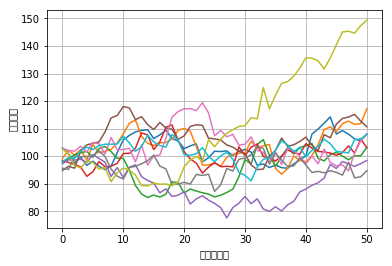

In [30]:
import matplotlib.pyplot as plt
plt.plot(S[:,:10])#选取前十条路径
plt.grid(True)
plt.xlabel('模拟时间点')
plt.ylabel('指数水平')
plt.show()

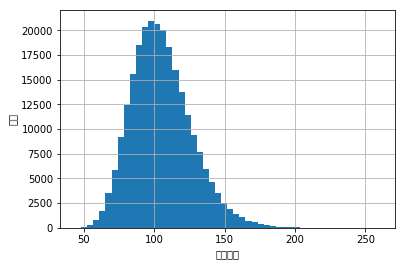

In [31]:
plt.hist(S[-1],bins=50)
plt.grid(True)
plt.xlabel('指数水平')
plt.ylabel('频数')
plt.show()#模拟期末指数水平的分布，应该近似为正态分布

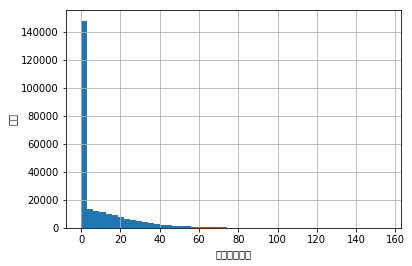

In [32]:
plt.hist(np.maximum(S[-1]-K,0),bins=50)
plt.grid(True)
plt.xlabel('期权期末价值')
plt.ylabel('频数')
plt.show()#模拟期权期末价值的分布

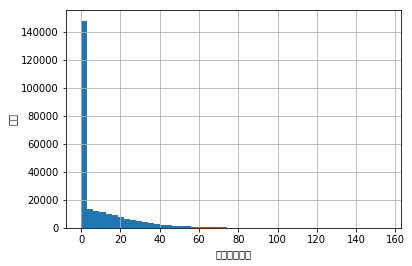

In [32]:
plt.hist(np.maximum(S[-1]-K,0),bins=50)
plt.grid(True)
plt.xlabel('期权期末价值')
plt.ylabel('频数')
plt.show()#模拟期权期末价值的分布